# rStar-Math (Self-play muTuAl Reasoning)

## Components:
1. MCTS --> Smart gambler (could increase simulations per iteration to build confidence)
2. Beam Search --> Focuses the race, keeping the `k` most promising solution trajectories at each step
3. Rich Set of Reasoning Actions --> Promote human like decision making
4. Mutual Consistency -->  Peer2peer feedback (if you and your friend got the same answer. Then you have a higher confidence you are both right)
5. Tree Nodes --> Act as a logbook entry (stores all the vital information about a specific point in the problem solving process)
6. LLM --> Powerful AI consultant/expert
7. Smart judge --> Checks if 2 outputs are equivalent (0.5 vs 1/2 vs \frac{1}{2})

In [2]:
from getpass import getpass
from dotenv import load_dotenv
import os
from openai import OpenAI

load_dotenv()
groq_key = os.getenv("GROQ_KEY", "Empty")

model = getpass("Enter the model name: ")
api_endpoint = getpass("Enter the API endpoint (default: https://api.openai.com): ")
# Models: "llama3-8b-8192", "llama3-70b-8192"
# Endpoint: "https://api.groq.com/openai"

api_endpoint = api_endpoint if api_endpoint else "https://api.openai.com"
api_key = groq_key

openai_api_base = f"{api_endpoint}/v1"

print(f"Model: {model}")
print(f"API Endpoint: {api_endpoint}")
print(f"OpenAI API Base: {openai_api_base}")
if api_key == "Empty":
    print("No API key needed.")
else:
    print(f"API Key Set")

client = OpenAI( # Intialize the OpenAI client to be used in rStar
    api_key=api_key,
    base_url=openai_api_base
)

Model: llama3-70b-8192
API Endpoint: https://api.groq.com/openai
OpenAI API Base: https://api.groq.com/openai/v1
API Key Set


In [ ]:
import math, random, re
import numpy as np

ground_truth_answer = "x = 1.6, y = 5.7"

class Node:
    def __init__(self, question, state, action=None, parent=None):
        self.state = state
        self.action = action # Action taken to reach this node
        self.parent = parent
        self.original_question = question
        self.current_question = question
        self.is_answered = False
        self.children = []
        self.visits = 0
        self.value = 0
        # Add unique identifier to the node

    def is_fully_expanded(self):
        # Right now every action is expanded --> so as long as there are children, the node is fully expanded (could change this if you want multiple A1,A2,A3 for example coming from 1 node)
        return len(self.children) > 0 or self.is_answered
    
    def best_child(self, exploration_weights=1.41):
        choices_weights = []
        for child in self.children:
            if child.is_answered: # If the child is a terminal node, we don't want to explore it
                print(f"Child {child.action} is answered, setting weight to -1")
                weight = -1
            elif child.visits == 0:
                weight = float('inf') # Prioritize unexplored nodes
            else:
                weight = (child.value / child.visits) + exploration_weights * math.sqrt(math.log(self.visits) / child.visits) # UCT calculation
            choices_weights.append(weight)
        return self.children[np.argmax(choices_weights)]
    
    def most_visited_child(self): # This is used to pull the best trajectory from the MCTS tree once its generation is done (best trajectory == most likely to be the correct answer)
        return max(self.children, key=lambda child: child.visits) # Return the child with the most visits
    
    def add_child(self, child_node): # Utility function used to expand the tree
        self.children.append(child_node)

class rStar:
    def __init__(self, question, num_rollouts=1, iterations=2, children_per_action=1):
        self.root = Node(question, "Begin answering the question")
        self.question = question
        self.num_rollouts = num_rollouts
        self.iterations = iterations
        self.children_per_action = children_per_action

    def search(self):
        for i in range (self.iterations):
            print(f"Iteration {i+1}/{self.iterations}")
            node = self.select(self.root)
            print(f"Selected node: {node.action}")
            if node.action == 'A2' and not node.is_answered: # Error occured in previous A2 prompt
                reward = self.complete_A2(node, ground_truth_answer)
                node.is_answered = True
                self.backpropagate(node, reward)
                continue
            if not node.is_fully_expanded():
                random_child = self.expand(node)
            reward = self.simulate(random_child)
            print(f"Simulated reward: {reward}")
            self.backpropagate(random_child, reward) # Backpropagate from the child upwards
            print("=================================================")
        print(f"Visits to most visited child: {self.root.most_visited_child().visits}")
        return self.root.most_visited_child().state

    def select(self, node):
        while node.is_fully_expanded() and node.children:
            node = node.best_child() # Must check that the node is not answered in the best_child function
        return node
    
    def expand(self, node): # Working as exptected (but might have to fix the state the children are initialized with)
        actions = self.get_valid_actions(node)
        print(f"Node action: {node.action}\nValid actions: {actions}\n")

        if node.is_answered: # Should never be reached since this is accounted for in the best_child function
            print(f"Selected node {action} is terminal, no further expansion.")
            return None # Terminal node
        
        for action in actions:  # Expand every valid action
            for i in range(self.children_per_action):
                print(f"\n-----Expanding node {i} with action: {action}-----\n")
                action_prompt_result, rating = self.create_prompt_and_execute(node.current_question, node.state, action)
                if rating != -1:
                    print("Is Answered, Rating:", rating)
                print(f"{action} response:\n\n {action_prompt_result}\n------------------------------------------")
                child_node = Node(node.original_question, action_prompt_result, action=action, parent=node)
                if rating != -1:
                    child_node.is_answered = True
                node.add_child(child_node)
                if child_node.is_answered:
                    self.backpropagate(child_node, rating) # Backpropagate the reward to the parent node of answered children

        # Any answered nodes should not be returned here to be simulated
        unanswered_children = [child for child in node.children if not child.is_answered]
        return random.choice(unanswered_children) # Return a random unanswered child, which will be simulated
    
    def simulate(self, node):
        # Have a check to see if the node is a terminal node (already answered) --> then just rate the node without simulating
        print(f"Simulating node: {node.action}")
        total_rating = 0
        for i in range(self.num_rollouts):
            rating = self.simulate_then_rate(node.original_question, node.state, ground_truth_answer)
            total_rating += rating
            print(f"Simulation {i+1}/{self.num_rollouts} rating: {rating}")
        return round(total_rating / self.num_rollouts, 2) # Return the average rating of the rollouts
    
    def backpropagate(self, node, reward):
        while node is not None:
            node.visits += 1
            node.value += reward
            node = node.parent

    def get_valid_actions(self, node): # Utility function
        actions = []

        if node.parent is None: # Root node
            actions = ["A1", "A2", "A3", "A5"]
        else:
            if node.action == "A1":
                actions = ["A1", "A2", "A3"]
            elif node.action == "A2":
                actions = []
            elif node.action == "A3":
                actions = ["A1", "A2", "A3", "A4"]
            elif node.action == "A4":
                actions = ["A1", "A2", "A3"]
            elif node.action == "A5":
                actions = ["A1", "A2", "A3"]
        
        return actions
    
    # ----------------- LLM-Calling Functions -----------------
    
    def chat_completion_request_openai(self, prompt):
        messages = [
            {"role": "user", "content": prompt}
        ]
        chat_response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=1.0,
            max_tokens=1500,
        )
        if chat_response.choices:
            completion_text = chat_response.choices[0].message.content
        else:
            completion_text = "No response from the model."
        return completion_text
    

    def create_prompt_and_execute(self, question, state, action):
        prompts = {
                "A1": f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "Please propose the next one-step thought to advance the reasoning process. "
            "Focus only on the immediate next step without solving the entire problem. "
            "Ensure the step is logically consistent with the existing reasoning steps. "
            "Do not provide the final answer or skip steps. Unless the next step clearly results in the final answer. "
            "Think step by step and provide only one reasoning step.",
                "A2": f"Question: {question}\n"
                f"Existing Reasoning Steps: {state}\n"
            "You must now complete the reasoning process to solve the problem entirely. "
            "Think step by step and ensure logical consistency with the existing reasoning steps. "
            "Provide the final answer at the end of your response in the following format: 'The Final Answer is: <your answer>'. "
            "Do not skip steps or provide incomplete reasoning. "
            "Ensure that your response is comprehensive and logically sound.",
                "A3": f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "Please propose the next sub-question to simplify the problem further. "
            "After proposing the sub-question, provide its answer. "
            "Ensure the sub-question logically follows from the existing reasoning steps. "
            "Do not solve the entire problem or skip intermediate sub-questions. "
            "Think step by step and provide only one sub-question and its answer.",
                "A4": f"Sub-Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "The sub-question might have been answered incorrectly. "
            "Please re-answer the last sub-question using few-shot chain-of-thought reasoning. "
            "Focus only on answering the sub-question accurately and logically. "
            "Do not reference the original answer or provide additional sub-questions. "
            "Provide a detailed explanation and a verified final answer to the sub-question. "
            "Do not provide the final answer to the original question or skip steps. Unless answering the sub-question clearly results in the final answer to the original question. "
            "Ensure logical consistency in your reasoning.",
                "A5": f"Original Question: {question}\n"
            "The original question might be misunderstood or unclear. "
            "Please rephrase the question to make it simpler and easier to understand. "
            "Clearly list all conditions and constraints provided in the problem statement. "
            "Ensure that no information is lost or altered during the rephrasing process. "
            "Do not solve the question or provide an answer.",
        }
        if action != 'A2':
            prompt = (
                prompts[action] +
                "\n\nIMPORTANT: If your reasoning leads to the final answer of the original question, you MUST explicitly state it in the following format at the end of your response: 'The Final Answer is: <your answer>'."
                "\nIf you are answering a sub-question, you MUST clearly provide the final answer to that sub-question in the following format instead: 'The Sub-Question Answer is: <your answer>'\n"
                "\nEnsure that this format is strictly followed to avoid ambiguity.\n"
                "\nDo not include the text 'The Final Answer is: <your answer>' or 'The Sub-Question Answer is: <your answer>' in your response otherwise\n"
            )
        else:
            prompt = prompts[action]

        action_response = self.chat_completion_request_openai(prompt)
        cumulative_state = state + "\n\n-------------------NEXT STEP-------------------\n\n" + action_response # Previous state + new_state (this should be optimized in the future to better effect downstream nodes, ESPECIALLY for larger problems)

        rating = -1 # Initialize rating as -1
        try:
            if re.search(r"The Final Answer is:", cumulative_state):
                rating = self.rate_final_answer(question, cumulative_state)
        except Exception as e:
            print(f"Error checking for final answer: {e}")

        return cumulative_state, rating


    def simulate_then_rate(self, question, state, expected_answer="Not provided"):
        prompt = (
            f"Question: {question}\n"
            f"Existing Reasoning Steps: {state}\n"
            "Please propose the remaining reasoning steps to solve the problem completely. "
            "Think step by step and ensure logical consistency with the existing reasoning steps. "
            "Provide the final answer at the end of the reasoning process. "
            "Do not skip steps or provide incomplete reasoning."
        )
        simulated_answer = self.chat_completion_request_openai(prompt)
        
        return self.rate_final_answer(question, state+"\n\n"+simulated_answer, expected_answer) # Simulated trajectory is not saved, only the rating is used to backpropagate the reward
    

    def complete_A2(self, node, expected_answer="Not provided"):
        prompt = (
            f"Question: {node.original_question}\n"
            f"Existing Reasoning Steps: {node.state}\n"
            "Please propose the remaining reasoning steps to solve the problem completely. "
            "Think step by step and ensure logical consistency with the existing reasoning steps. "
            "Provide the final answer at the end of the reasoning process. "
            "You MUST explicitly state it in the following format at the end of your response: 'The Final Answer is: <your answer>'. "
            "Do not skip steps or provide incomplete reasoning. "
        )
        rest_of_answer = self.chat_completion_request_openai(prompt)
        node.state = node.state+"\n\n"+rest_of_answer # Append the rest of the answer to the state

        return self.rate_final_answer(node.original_question, node.state, expected_answer) # Simulated trajectory is not saved, only the rating is used to backpropagate the reward
    

    def rate_final_answer(self, question, state, expected_answer="x = 1.6, y = 5.7"): # Called when a particular node is a terminal node (i.e. the answer is given)
        rating_prompt = (
            f"Question: {question}\n"
            f"Answer: {state}\n"
            f"Ground-truth Answer: {expected_answer}\n"
            "As an expert on this topic, please provide a detailed critique of the answer. "
            "Rate the answer based on correctness, completeness, and logical consistency. "
            "First state whether the answer is correct or incorrect. "
            "Provide only a critique, not a suggested answer. "
            "Then, rate the answer on a scale of 0 to 100. "
            "The response MUST be in the following format:\n"
            "Critique: <detailed critique>\n"
            "Rating: <numeric rating>\n"
        )
        rating_response = self.chat_completion_request_openai(rating_prompt)

        try:
            match = re.search(r"Rating:\s*(\d+)", rating_response) # Extract rating to be used in the UCT calculation
            if match:
                rating = int(match.group(1))
                if rating > 95: # Paper limits the rating to a maximum of 95 (maybe 96+ causes poor MCTS performance)
                    rating = 95
                rating = float(rating)/100
            else:
                raise ValueError("Rating not found in the response.")
        except Exception as e:
            print(f"Error extracting rating: {e}")
            print(f"Rating response was: {rating_response}")
            rating = 0

        return rating # Simulated trajectory is not saved, only the rating is used to backpropagate the reward
        

In [10]:
# Run rStar
question = "Solve the system of linear equations:\n\nx + 2y = 13\n3x - 4y = -18"
rstar = rStar(question, num_rollouts=2, iterations=10, children_per_action=1)
rstar.search()

# TODO:
"""
1. Implement this for 1 coding problem 
2. Experiment between having multiple same actions coming from the same node
3. See if the errors made seem to be human-like or just super random (and make no logical sense)
4. Try out different models (llama3-8b-8192, llama3-70b-8192, llama3-70b-4096)
5. Try to further optimize prompts for A1, A2, A3, A4, A5, and some other things.
"""

# ---------- FUTURE ----------

# TODO implementation of post-processing steps:
"""
Extract full-trajectories when rStar is done executing

Rate trajectories

Mutual consistency --> to make sure full-trajectories are logically sound with higher confidence

MAYBE --> go to every non terminal node and one-shot a solution from there to make sure every trajectory is complete
"""

Iteration 1/10
Selected node: None
Node action: None
Valid actions: ['A1', 'A2', 'A3', 'A5']


-----Expanding node 0 with action: A1-----

A1 response:

 Begin answering the question

-------------------NEXT STEP-------------------

Let's begin by multiplying the two equations by suitable multipliers such that the coefficients of y's in both equations are the same.

Next step: Multiply the first equation by 2 and the second equation by 1, so that the coefficients of y's in both equations are the same.
------------------------------------------

-----Expanding node 0 with action: A2-----

Is Answered, Rating: 0.95
A2 response:

 Begin answering the question

-------------------NEXT STEP-------------------

Let's solve the system of linear equations step by step.

Given equations:
x + 2y = 13 ... (1)
3x - 4y = -18 ... (2)

First, we can solve equation (1) for x:
x = 13 - 2y

Now, substitute this expression for x in equation (2):
3(13 - 2y) - 4y = -18

Expand and simplify:
39 - 6y - 4y = 

'\nExtract full-trajectories when rStar is done executing\n\nRate trajectories\n\nMutual consistency --> to make sure full-trajectories are logically sound with higher confidence\n\nMAYBE --> go to every non terminal node and one-shot a solution from there to make sure every trajectory is complete\n'

/var/folders/lx/b4qt1jss59bdv0vzs87ly60h0000gn/T/ipykernel_69088/3243732240.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


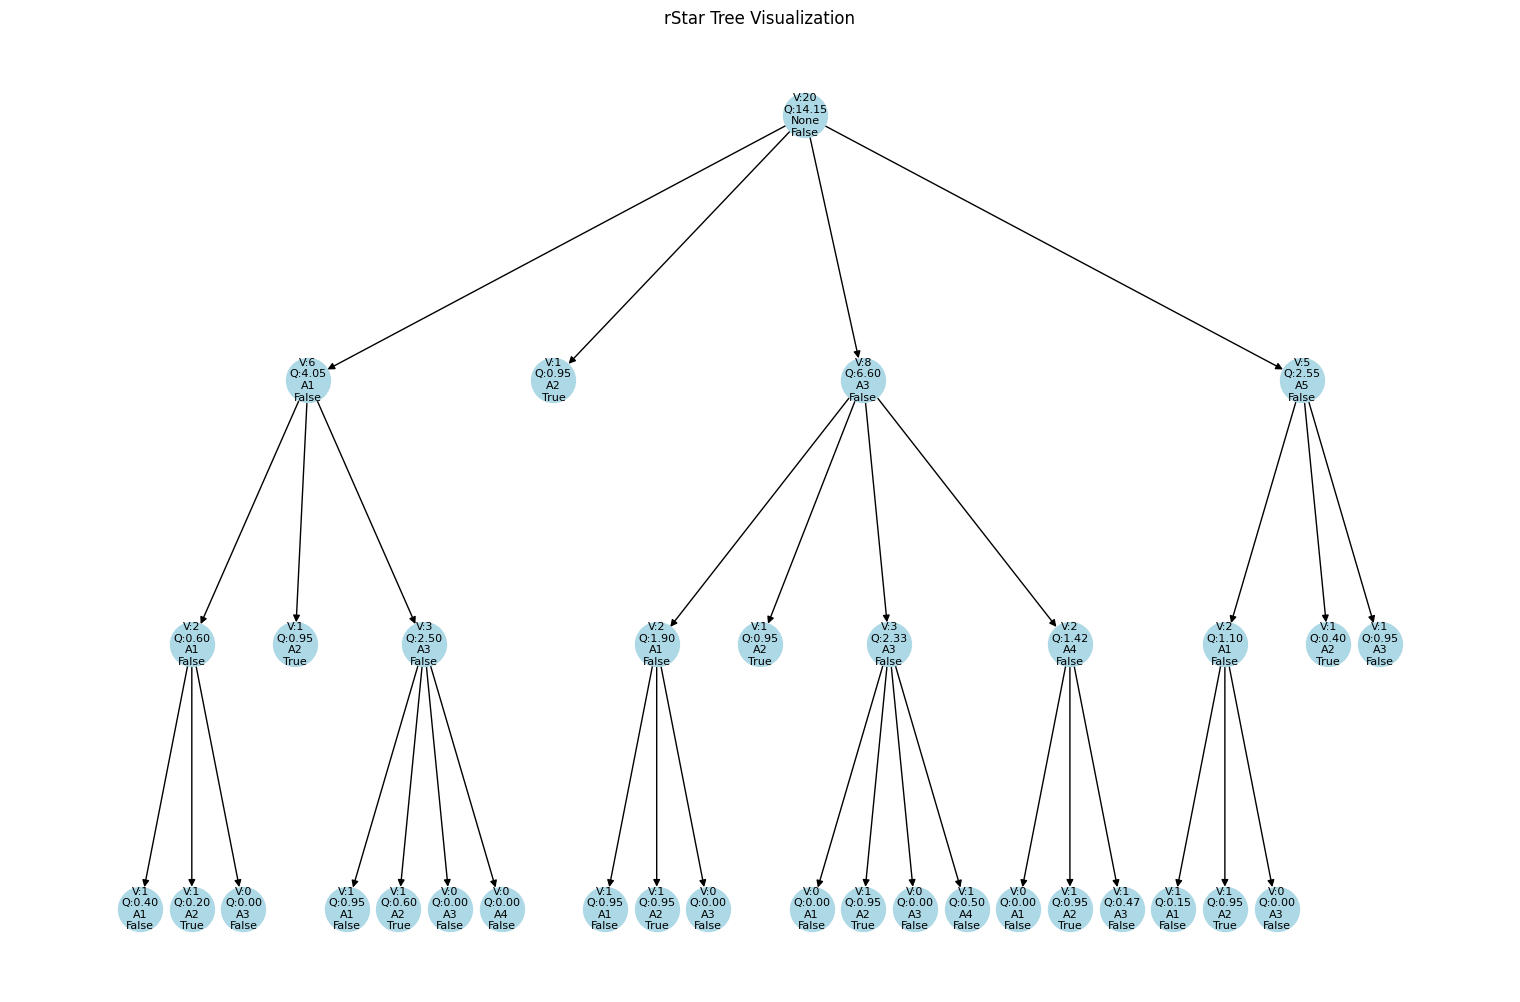

In [11]:
# Visualize rStar tree
import matplotlib.pyplot as plt
import networkx as nx

def layout_tree(tree, node, depth=0, x_offset=[0], positions={}, level_height=1.5):
    """
    Reingold-Tilford-style layout: recursively assigns x/y positions to nodes with horizontal shifting
    to avoid overlaps.
    """
    children = list(tree.successors(node))
    if not children:
        # Leaf node: assign next available x
        x = x_offset[0]
        positions[node] = (x, -depth * level_height)
        x_offset[0] += 1
        return x

    child_xs = []
    for child in children:
        cx = layout_tree(tree, child, depth + 1, x_offset, positions, level_height)
        child_xs.append(cx)

    # Center current node over its children
    min_x, max_x = min(child_xs), max(child_xs)
    x = (min_x + max_x) / 2
    positions[node] = (x, -depth * level_height)
    return x

def visualize_rstar_tree(mcts, max_nodes=100):
    graph = nx.DiGraph()
    node_labels = {}
    node_counter = [0]
    node_ids = {}

    def add_edges(node, parent_id=None):
        if node_counter[0] >= max_nodes:
            return
        node_id = node_counter[0]
        node_counter[0] += 1
        node_ids[node] = node_id

        label = (
            f"V:{getattr(node, 'visits', '?')}\n"
            f"Q:{getattr(node, 'value', '?'):.2f}\n"
            f"{getattr(node, 'action', '?')}\n"
            f"{getattr(node, 'is_answered', '?')}"
        )
        node_labels[node_id] = label
        graph.add_node(node_id)
        if parent_id is not None:
            graph.add_edge(parent_id, node_id)

        for child in getattr(node, 'children', []):
            add_edges(child, node_id)

    # Build the graph from the MCTS root
    add_edges(mcts.root)

    # Assign layout positions (no overlaps)
    positions = {}
    layout_tree(graph, 0, x_offset=[0], positions=positions, level_height=1.8)

    # Auto-adjust figure size
    num_leaves = sum(1 for n in graph.nodes if graph.out_degree(n) == 0)
    width = max(12, num_leaves * 0.6)
    depth = max(abs(y) for x, y in positions.values()) + 1
    height = max(6, depth * 1.5)

    # Draw tree
    plt.figure(figsize=(width, height))
    nx.draw(
        graph,
        pos=positions,
        with_labels=False,
        node_size=1000,
        node_color="lightblue"
    )
    nx.draw_networkx_labels(graph, pos=positions, labels=node_labels, font_size=8)
    plt.title("rStar Tree Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_rstar_tree(rstar)

In [12]:
# Jsonify rStar tree
import json

def jsonify_rstar_tree(node):
    return {
        "action": node.action if node.action else "Root",
        "summary": node.state,
        "children": [jsonify_rstar_tree(child) for child in node.children]
    }

tree_json = jsonify_rstar_tree(rstar.root)
with open("rstar_tree.json", "w") as f:
    json.dump(tree_json, f, indent=4)

print("Tree successfully saved to rstar_tree.json")

Tree successfully saved to rstar_tree.json
